<a href="https://colab.research.google.com/github/FreNzQuiN/Collab_Stable-Diffusion/blob/main/InlineSD.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install -q --upgrade diffusers invisible_watermark transformers accelerate safetensors compel

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.4/44.4 kB 3.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 75.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.7/9.7 MB 90.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.5/4.5 MB 96.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 112.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 83.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 60.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 21.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/

In [ ]:
import torch
from torch import autocast
from diffusers import StableDiffusionXLPipeline, EulerAncestralDiscreteScheduler, DDIMScheduler

model = "linaqruf/animagine-xl"

pipe = StableDiffusionXLPipeline.from_pretrained(
    model,
    torch_dtype=torch.float16,
    use_safetensors=True,
    safety_checker = None,
    requires_safety_checker = False,
    variant="fp16",
    )
pipe.scheduler = DDIMScheduler(beta_start=0.00085, beta_end=0.012, beta_schedule="scaled_linear", clip_sample=False, set_alpha_to_one=False)
pipe.to('cuda')


The cache for model files in Transformers v4.22.0 has been updated. Migrating your old cache. This is a one-time only operation. You can interrupt this and resume the migration later on by calling `transformers.utils.move_cache()`.


0it [00:00, ?it/s]

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


model_index.json:   0%|          | 0.00/582 [00:00<?, ?B/s]

Fetching 18 files:   0%|          | 0/18 [00:00<?, ?it/s]

text_encoder_2/config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

text_encoder/config.json:   0%|          | 0.00/560 [00:00<?, ?B/s]

tokenizer/tokenizer_config.json:   0%|          | 0.00/737 [00:00<?, ?B/s]

model.fp16.safetensors:   0%|          | 0.00/1.39G [00:00<?, ?B/s]

scheduler/scheduler_config.json:   0%|          | 0.00/479 [00:00<?, ?B/s]

model.fp16.safetensors:   0%|          | 0.00/246M [00:00<?, ?B/s]

tokenizer/merges.txt:   0%|          | 0.00/525k [00:00<?, ?B/s]

tokenizer/special_tokens_map.json:   0%|          | 0.00/472 [00:00<?, ?B/s]

tokenizer_2/tokenizer_config.json:   0%|          | 0.00/725 [00:00<?, ?B/s]

tokenizer/vocab.json:   0%|          | 0.00/1.06M [00:00<?, ?B/s]

tokenizer_2/special_tokens_map.json:   0%|          | 0.00/460 [00:00<?, ?B/s]

unet/config.json:   0%|          | 0.00/1.71k [00:00<?, ?B/s]

diffusion_pytorch_model.fp16.safetensors:   0%|          | 0.00/5.14G [00:00<?, ?B/s]

vae/config.json:   0%|          | 0.00/607 [00:00<?, ?B/s]

diffusion_pytorch_model.fp16.safetensors:   0%|          | 0.00/167M [00:00<?, ?B/s]

Keyword arguments {'safety_checker': None, 'requires_safety_checker': False} are not expected by StableDiffusionXLPipeline and will be ignored.


Loading pipeline components...:   0%|          | 0/7 [00:00<?, ?it/s]

StableDiffusionXLPipeline {
  "_class_name": "StableDiffusionXLPipeline",
  "_diffusers_version": "0.32.2",
  "_name_or_path": "linaqruf/animagine-xl",
  "feature_extractor": [
    null,
    null
  ],
  "force_zeros_for_empty_prompt": true,
  "image_encoder": [
    null,
    null
  ],
  "scheduler": [
    "diffusers",
    "DDIMScheduler"
  ],
  "text_encoder": [
    "transformers",
    "CLIPTextModel"
  ],
  "text_encoder_2": [
    "transformers",
    "CLIPTextModelWithProjection"
  ],
  "tokenizer": [
    "transformers",
    "CLIPTokenizer"
  ],
  "tokenizer_2": [
    "transformers",
    "CLIPTokenizer"
  ],
  "unet": [
    "diffusers",
    "UNet2DConditionModel"
  ],
  "vae": [
    "diffusers",
    "AutoencoderKL"
  ]
}

In [ ]:
num=0
def disabled_safety_checker(images, clip_input):
    if len(images.shape)==4:
        num_images = images.shape[0]
        return images, [False]*num_images
    else:
        return images, False
pipe.safety_checker = disabled_safety_checker

  0%|          | 0/25 [00:00<?, ?it/s]

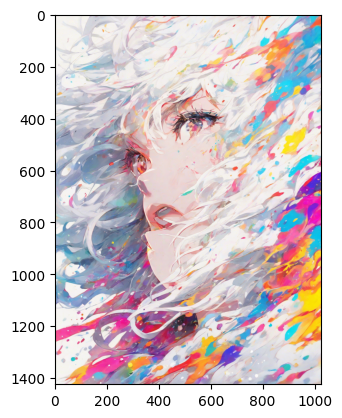

In [ ]:
from compel import Compel, ReturnedEmbeddingsType
import matplotlib.pyplot as plt
from PIL import Image
import random
import torch, gc

prompt = "anime girl white hair, vivid color, art splash"
negative_prompt = "lowres, bad anatomy, bad hands, text, error, missing fingers, extra digit, fewer digits, cropped, worst quality, low quality, normal quality, jpeg artifacts, signature, watermark, username, blurry"
outputbase = "/content/anime_girl"
compel = Compel(
  tokenizer=[pipe.tokenizer, pipe.tokenizer_2] ,
  text_encoder=[pipe.text_encoder, pipe.text_encoder_2],
  returned_embeddings_type=ReturnedEmbeddingsType.PENULTIMATE_HIDDEN_STATES_NON_NORMALIZED,
  requires_pooled=[False, True]
)
conditioning, pooled = compel(prompt)
W = 1024
H = 1424
setseed = random.randint(0,1000000)

for x in range(1):
  gc.collect()
  torch.cuda.empty_cache()
  image = pipe(
      #prompt_embeds=conditioning, pooled_prompt_embeds=pooled,
      prompt=prompt,
      negative_prompt=negative_prompt,
      seed=setseed,
      width=W,
      height=H,
      guidance_scale=6,
      guidance_rescale=0.9,
      target_size=(W,H),
      original_size=(4096,4096),
      num_inference_steps=25
      ).images[0]
  output=f"{outputbase}{num}_{setseed}.png"
  image.save(output)
  image = Image.open(output)
  plt.imshow(image)
  num=num+1
gc.collect()
torch.cuda.empty_cache()


In [ ]:
import torch, gc
gc.collect()
torch.cuda.empty_cache()

In [ ]:
!pip install numba
from numba import cuda
device = cuda.get_current_device()
device.reset()

In [ ]:
!rm "/content/"*.png

In [ ]:
#@title (STEP 1) Connect to Google Drive
from google.colab import drive
drive.mount('/content/drive')

TheDate = "2024-12-04" #@param {type:'string'}
!mv "/content/outputs/" "/content/drive/MyDrive/"{Thedate}/

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
mv: cannot stat '/content/outputs/': No such file or directory


In [ ]:
!mkdir outputs

In [ ]:
!mv "/content/"*.png "/content/outputs"

In [ ]:
!smi-nvidia

/bin/bash: line 1: smi-nvidia: command not found
